In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '..')
from utils.config import PATHS

# Load data

In [2]:
# all covid data with classifier predictions

path = PATHS.getpath('data_covid')
df = pd.read_pickle(path / 'covid_data.pkl').astype({'MDN': int})
df.Notitiedatum = pd.to_datetime(df.Notitiedatum)

In [3]:
# time-series annotations of one patient (1165165)

path = PATHS.getpath('data_timeseries_annot')
pat = pd.read_excel(path / 'from_avelli/IAA-1165165-n.recs-43.xlsx')
pat.Notitiedatum = pd.to_datetime(pat.Notitiedatum)

# Process ADM levels

In [4]:
# select the relevant patient from the classifier data

algo = df.loc[lambda df: df.MDN.isin(pat.MDN)].sort_values('Notitiedatum')

In [5]:
# remove notes of type 'Brief' (n=6)
# align gold and predicted labels for ADM

get_dom = lambda df, dom: df.query("Typenotitie not in ['Brief']").set_index('Notitiedatum')[dom]
dom = 'ADM_lvl'
source = pd.concat([
    get_dom(algo, dom).rename('classif'),
    get_dom(pat, dom).rename('gold'),
], axis=1)

In [6]:
source

,classif,gold
Notitiedatum,,
2020-03-25,3.727051,4.0
2020-03-27,1.832357,1.0
2020-03-27,1.538462,1.0
2020-03-27,1.888672,NaN
2020-03-27,2.014323,2.0
2020-03-27,1.952148,1.0
2020-03-28,1.397461,1.0
2020-03-28,2.022786,1.0
2020-03-28,2.586426,1.0


# Plot ADM levels

The "broken axis" plot code is based on: [https://matplotlib.org/stable/gallery/subplots_axes_and_figures/broken_axis.html](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/broken_axis.html)

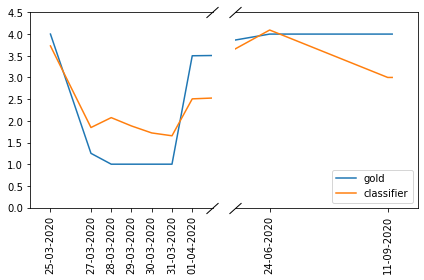

In [9]:
# if there are multiple notes on the same date, a mean level is plotted
data = source.resample('d').mean().interpolate()

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, tight_layout=True)
fig.subplots_adjust(wspace=0.05)

for ax in (ax1, ax2):
    ax.plot(data.gold, label='gold')
    ax.plot(data.classif, label='classifier')

    ticks = source.dropna(subset=['gold']).index.unique()
    ax.set_xticks(ticks)
    ax.set_xticklabels([f"{i:%d-%m-%Y}" for i in ticks])

    for label in ax.get_xticklabels():
        label.set_rotation(90)

ax1.set_ylim(0, 4.5)
ax1.set_xlim(
    pd.Timestamp('2020-03-24').to_pydatetime(),
    pd.Timestamp('2020-04-02').to_pydatetime()
)
ax2.set_xlim(
    pd.Timestamp('2020-06-01').to_pydatetime(),
    pd.Timestamp('2020-10-01').to_pydatetime()
)
ax2.yaxis.set_ticks_position('none')
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)

# add slanted lines where the axis breaks
d = 0.9
kwargs = dict(marker=[(-1, -d), (1, d)],
    markersize=12,
    linestyle="none", color='k', mec='k', mew=1, clip_on=False
)
ax1.plot([1, 1], [1, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 0], [0, 1], transform=ax2.transAxes, **kwargs)
ax2.legend(loc='lower right')
plt.savefig('figures/recpattern.png', dpi=300)